# Import dependencies

In [65]:
from __future__ import print_function
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
import re

# Import data
This corpus of tweets comes from <i> Demographic Dialectal Variation in Social Media: A Case Study of African-American English. Su Lin Blodgett, Lisa Green, and Brendan O'Connor. Proceedings of EMNLP 2016. </i> <a href="https://www.aclweb.org/anthology/D16-1120/"> [pdf] </a> <a href="http://slanglab.cs.umass.edu/TwitterAAE/"> [more info] </a>

In [53]:
columns =["Text","AA","White"]
tweets = pd.read_csv("TwitterAAE-full-v1/twitteraae_all_aa",names=columns,delimiter="\t",nrows=100000,usecols=[5,6,9])

In [54]:
float_check = re.compile("[0-1]\.[0-9]+$")
tweets = tweets[tweets['AA'].astype(str).str.contains(float_check)]
tweets = tweets[tweets['White'].astype(str).str.contains(float_check)]
tweets.AA = tweets.AA.astype(float)
tweets.White = tweets.White.astype(float)

In [55]:
tweets.head()

,Text,AA,White
0,Click Clack Motha Fucka I ain't tryin to hear ...,0.894545,0.089091
1,Man imissed a called from my bae hella mad -_-...,0.942000,0.000000
2,@devontekthomas OMG I keep sayin boo wen I mea...,0.951111,0.017778
3,@devontekthomas I did not mean to say dat,0.957143,0.008571
4,@devontekthomas awww u do too,0.975000,0.015000


In [59]:
def race_count_histogram(tweets,title):
    tweets[tweets.columns[1]].hist(color='blue',alpha=.3)
    tweets[tweets.columns[2]].hist(color='orange',alpha=.3)
    handles = [Rectangle((0,0),1,1,color=c,ec="k",alpha=.2) for c in ['blue','orange']]
    labels= [tweets.columns[1],tweets.columns[2]]
    plt.title(title)
    plt.legend(handles, labels)
    plt.show()

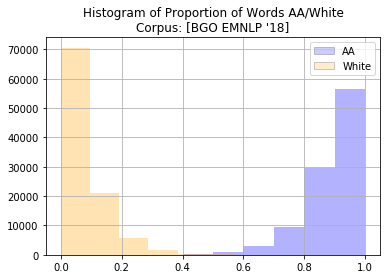

In [60]:
race_count_histogram(tweets,"Histogram of Proportion of Words AA/White\nCorpus: [BGO EMNLP '16]")

# Addings more tweets

The histogram above undercores the need for more tweet diversity. I used the model described in the paper above (available <a href=https://github.com/slanglab/twitteraae> here</a>) and the <a href="https://www.kaggle.com/kazanova/sentiment140/data#"> tweet corpus here </a> to enrich my list of tweets. The tweet texts and predicted classes are available in <b> race_labeled_tweets_from_sentiment.csv </b>

In [29]:
extra_tweets = pd.read_csv("race_labeled_tweets_from_sentiment.csv")
extra_tweets.head()

,Text,AA,White
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0.202300,0.333193
1,is upset that he can't update his Facebook by ...,0.172174,0.583695
2,@Kenichan I dived many times for the ball. Man...,0.102774,0.730196
3,my whole body feels itchy and like its on fire,0.185610,0.390145
4,"@nationwideclass no, it's not behaving at all....",0.142938,0.457326


In [34]:
all_tweets=tweets.append(extra_tweets).reset_index(drop=True)
all_tweets.head()

,Text,AA,White
0,Click Clack Motha Fucka I ain't tryin to hear ...,0.894545,0.089091
1,Man imissed a called from my bae hella mad -_-...,0.942000,0.000000
2,@devontekthomas OMG I keep sayin boo wen I mea...,0.951111,0.017778
3,@devontekthomas I did not mean to say dat,0.957143,0.008571
4,@devontekthomas awww u do too,0.975000,0.015000


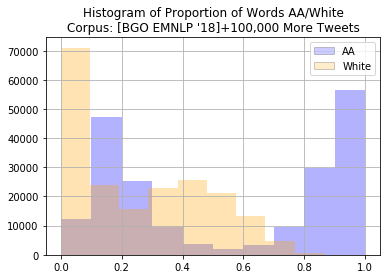

In [64]:
race_count_histogram(all_tweets,"Histogram of Proportion of Words AA/White\nCorpus: [BGO EMNLP '18]+100,000 More Tweets")

This seems like a more reasonable mix

# Creating a biased model

Our goal is to create a bias detection engine. This notebook is designed to train a biased model that the detection engine will flag. In this case, we will train a shallow neural network that will take as input a feature vector representing the tweet. 

For this toy example, we will represent each tweet as a vector of its tokens' <b><i>TFIDF</i></b>. 
<center>
$tfidf(t,d,D) = tf(t,d)\times idf(t,D)$  ... and<br>
$idf(t,D) = log \frac{ \text{| } D \text{ |} }{ 1 + \text{| } \{ d \in D : t \in d \} \text{ |} }$
</center>

Then we will make a subjective judgement on the tweets. This is meant to mimic common text labeling tasks such as 
- Hate speech detection
- Education level classification
- Tweet recommendation

In this case, we will perform education level classification. Since we want to produce a biased (read: <i> racist </i>) model, we will assign labels as follows:
<center>
$educlabel1(tweet) = min(8,2 \times (\mathcal{Gauss}(tweet.AA,\,.2)\ + 6 \times \mathcal{Gauss}(tweet.White,\,.2))$ <br>
$educlabel2(tweet) = min(8,2 \times (\mathcal{Gauss}(tweet.AA,\,.5)\ + 6 \times \mathcal{Gauss}(tweet.White,\,.2))$ <br>
$educlabel3(tweet) = min(8,4 \times (\mathcal{Gauss}(tweet.AA,\,.2)\ + 4 \times \mathcal{Gauss}(tweet.White,\,.2))$ <br>
$educlabel(tweet) = max(int(\frac{educlabel1(tweet) + educlabel2(tweet) + educlabel3(tweet)}{3}),0)$
</center>
These labelers generally give more weight to words the model in the paper above considers "White" than to words it considers "AA," thereby giving White-sounding tweets a significant advantage when it comes to education level determinations. The aggregated label does not weight lablers according to their biases.

# Test out the formula

In [104]:
tweet = all_tweets.loc[1,:]
raw_score_1 = min(8,2*random.gauss(tweet.AA,.2) + 6*random.gauss(tweet.White,.2))
raw_score_2 = min(8,2*random.gauss(tweet.AA,.5) + 6*random.gauss(tweet.White,.2))
raw_score_3 = min(8,4*random.gauss(tweet.AA,.2) + 4*random.gauss(tweet.White,.2))
tweet_label = max(int((raw_score_1+raw_score_2+raw_score_3)/3),0)
print(tweet.Text + " : " + str(tweet_label))

Man imissed a called from my bae hella mad -_- @callme_KRAZII : 3


In [118]:
def label(tweet):
    raw_score_1 = min(8,2*random.gauss(tweet.AA,.2) + 6*random.gauss(tweet.White,.2))
    raw_score_2 = min(8,2*random.gauss(tweet.AA,.5) + 6*random.gauss(tweet.White,.2))
    raw_score_3 = min(8,4*random.gauss(tweet.AA,.2) + 4*random.gauss(tweet.White,.2))
    return max(int((raw_score_1+raw_score_2+raw_score_3)/3),0)

In [ ]:
labels = [label(all_tweets.loc[i,:]) for i in range(len(all_tweets))]
all_tweets["EducationLevel"] = labels

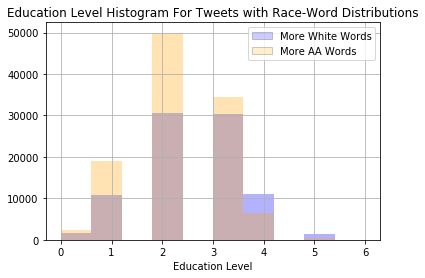

In [161]:
all_tweets[all_tweets.White > all_tweets.AA].EducationLevel.hist(color='blue',alpha=.3)
all_tweets[all_tweets.AA > all_tweets.White].EducationLevel.hist(color='orange',alpha=.3)
handles = [Rectangle((0,0),1,1,color=c,ec="k",alpha=.2) for c in ['blue','orange']]
labels= ["More White Words","More AA Words"]
plt.title("Education Level Histogram For Tweets with Race-Word Distributions")
plt.legend(handles, labels)
plt.xlabel("Education Level")
plt.show()




This histogram shows that the lablers were in fact biased against tweets with more African American English words.

# Train the model

## Tweets to TFIDF